In [7]:
import openmc
import numpy as np
from Meshing.Meshing import *
from Fields.Fields import *
from Kernels.Kernels import *
from Solvers.Solvers import *
from Subchannel.FluidRelation import FluidRelation
from Subchannel.Channel import Channel
from Subchannel.Channel import ChannelInterface
from Aux.CSVObjects import *
from Aux.ReactorPhysicsObjects import *

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle

import pandas as pd

from Data.msre_data import msre_data_dict

In [8]:
# FLUID
fluid = msre_data_dict['fluid']

### BC DATA ###
# mdot_csv = load_csv('Data/msre_flow_coastdown.csv')
mdot_csv = load_csv('Data/msre_flow_coastdown.csv')
MDOT_MAX = msre_data_dict['mdot_max']
START_TIME = -100
mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=START_TIME, x_label='time', y_label='mdot')

T_bc = msre_data_dict['temp_bc']
pressure_bc = msre_data_dict['pressure_bc']

In [9]:
# SET CHANNELS UP FROM FULL CORE SOLUTION (NEED TO RUN COASTDOWN SIMULATION FIRST)

# ch1 = all channels combined
# ch2 = bypass flow channel
ch = Channel.import_from_pkl(filename='Data/model_1_channels/all_channels_homogenized.pkl')

upper_plenum_channel = Channel.import_from_pkl(filename='Data/model_8_channels/upper_plenum.pkl')
lower_plenum_channel = Channel.import_from_pkl(filename='Data/model_8_channels/lower_plenum.pkl')
ex_channel = Channel.import_from_pkl(filename='Data/model_8_channels/external_loop.pkl')
downcomer_channel = Channel.import_from_pkl(filename='Data/model_8_channels/downcomer.pkl')


# set bcs for the channel array.
ch.set_bcs(pressure_bc=pressure_bc,
           T_bc=T_bc,
           mdot_bc=mdot_bc,
           tracer_name_value_pairs={}, tracer_bool=False, th_bool=True)




In [10]:
### PRINT CHANNEL RESIDENCE TIMES
print("CHANNEL RESIDENCE TIMES ARE ...")
print(ch.get_channel_residence_time())
print(upper_plenum_channel.get_channel_residence_time())
print(ex_channel.get_channel_residence_time())
print(downcomer_channel.get_channel_residence_time())
print(lower_plenum_channel.get_channel_residence_time())
print("total residence time =", ch.get_channel_residence_time()
      + upper_plenum_channel.get_channel_residence_time()
      + ex_channel.get_channel_residence_time()
      + downcomer_channel.get_channel_residence_time()
      + lower_plenum_channel.get_channel_residence_time())

CHANNEL RESIDENCE TIMES ARE ...
9.172500000000007
3.9000000000000066
7.017500000000015
1.3000000000000007
3.800000000000001
total residence time = 25.19000000000003


In [11]:
ch_to_up = ChannelInterface(ch1=ch, ch2=upper_plenum_channel)
up_to_ex = ChannelInterface(ch1=upper_plenum_channel, ch2=ex_channel)
ex_to_downcomer = ChannelInterface(ch1=ex_channel, ch2=downcomer_channel)
downcomer_to_lp = ChannelInterface(ch1=downcomer_channel, ch2=lower_plenum_channel)
lp_to_ch = ChannelInterface(ch1=lower_plenum_channel, ch2=ch)

In [12]:
# st.st. solution for thermal hydraulics
ch.solve_channel_TH(_dt=1e321)
ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

upper_plenum_channel.solve_channel_TH(_dt=1e321)
up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

ex_channel.solve_channel_TH(_dt=1e321)
ex_to_downcomer.update_interface_conditions(tracer_bool=False, th_bool=True)

downcomer_channel.solve_channel_TH(_dt=1e321)
downcomer_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

lower_plenum_channel.solve_channel_TH(_dt=1e321)
lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

# St.St. Solution for tracers
ch_outlet_value = 1.0
iter_num = 0
tracer_to_converge_on = 'c1'
while True:
  iter_num += 1
  ch.solve_all_tracers(_dt=1e321)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum_channel.solve_all_tracers(_dt=1e321)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  ex_channel.solve_all_tracers(_dt=1e321)
  ex_to_downcomer.update_interface_conditions(tracer_bool=True, th_bool=False)

  downcomer_channel.solve_all_tracers(_dt=1e321)
  downcomer_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum_channel.solve_all_tracers(_dt=1e321)
  lp_to_ch.update_interface_conditions(tracer_bool=True, th_bool=False)

  tracer_outlet_weighted_value = ch.tracers[tracer_to_converge_on].T[-1]
  diff = np.abs(1 - tracer_outlet_weighted_value/ch_outlet_value)

  ch_outlet_value = tracer_outlet_weighted_value
  print("Iteration nuimber", iter_num, " and diff is", diff)
  if diff < 1e-12:
    break

Iteration nuimber 1  and diff is 0.9999999930050246
Iteration nuimber 2  and diff is 0.0005542188029420414
Iteration nuimber 3  and diff is 0.0003963794942134502
Iteration nuimber 4  and diff is 0.00028344742829722325
Iteration nuimber 5  and diff is 0.00020266782204936273
Iteration nuimber 6  and diff is 0.0001448978659187583
Iteration nuimber 7  and diff is 0.00010358910584296055
Iteration nuimber 8  and diff is 7.405395147253024e-05
Iteration nuimber 9  and diff is 5.2938247722011944e-05
Iteration nuimber 10  and diff is 3.784266520623358e-05
Iteration nuimber 11  and diff is 2.705124844337714e-05
Iteration nuimber 12  and diff is 1.9336961106231065e-05
Iteration nuimber 13  and diff is 1.3822474073887925e-05
Iteration nuimber 14  and diff is 9.880546112506217e-06
Iteration nuimber 15  and diff is 7.062759252107753e-06
Iteration nuimber 16  and diff is 5.048549658215329e-06
Iteration nuimber 17  and diff is 3.608759891138291e-06
Iteration nuimber 18  and diff is 2.5795783121784766e-

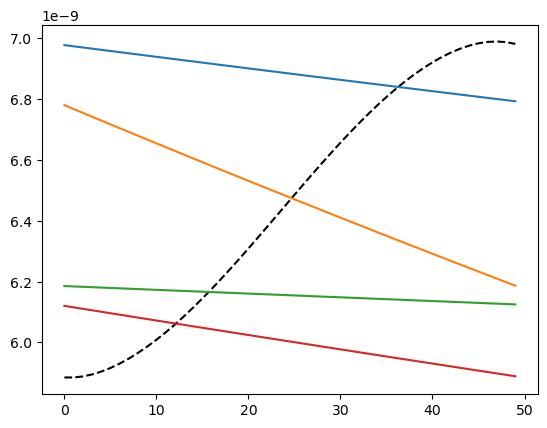

In [13]:
plt.plot(ch.tracers['c1'].T, 'k--')
plt.plot(upper_plenum_channel.tracers['c1'].T)
plt.plot(ex_channel.tracers['c1'].T)
plt.plot(downcomer_channel.tracers['c1'].T)
plt.plot(lower_plenum_channel.tracers['c1'].T)

In [14]:
total_source_times_V = ch.integrate_tracer_source(tracer_name='c1') + upper_plenum_channel.integrate_tracer_source(tracer_name='c1') + lower_plenum_channel.integrate_tracer_source(tracer_name='c1') + downcomer_channel.integrate_tracer_source(tracer_name='c1')

print(ch.integrate_tracer_source(tracer_name='c1')/total_source_times_V)
print(upper_plenum_channel.integrate_tracer_source(tracer_name='c1')/total_source_times_V)
print(lower_plenum_channel.integrate_tracer_source(tracer_name='c1')/total_source_times_V)
print(downcomer_channel.integrate_tracer_source(tracer_name='c1')/total_source_times_V)


0.8693971692826513
0.07832740490636377
0.031401999533857305
0.02087342627712754


In [15]:
# TIME SETTINGS
Tstart = -0.1
Tend = 100
nsteps = 10000

# TIMESTEPS
timesteps = np.linspace(Tstart, Tend, nsteps)

# Update old values in channel before starting simulation
ch.update_old_to_most_recent()
upper_plenum_channel.update_old_to_most_recent()
ex_channel.update_old_to_most_recent()
lower_plenum_channel.update_old_to_most_recent()
downcomer_channel.update_old_to_most_recent()

# Transient solver
t_prev = -1e321

# setup beff dict
beta_eff_dict_mc = {}

# Tracer names for stuff
tracer_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6']

for t_new in timesteps:
  # DT
  this_dt = t_new - t_prev
  # PRINT TIME INFORMATION
  print("NOW SOLVING AT TIME =", t_new, "| this_dt =", this_dt)
  # CHANGE MASS FLOW RATE AT CHANNEL INLET
  THIS_X_VALUE = t_new
  mdot_bc = MDOT_MAX / 100 * csv_interpolator(csv_df=mdot_csv, x_value=THIS_X_VALUE, x_label='time', y_label='mdot')
  ch.mdot_bc = mdot_bc
  print("\tmdot_bc =", mdot_bc)

  # THERMAL HYDRAULIC INFORMATION
  ch.solve_channel_TH(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=False, th_bool=True)

  upper_plenum_channel.solve_channel_TH(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=False, th_bool=True)

  ex_channel.solve_channel_TH(_dt=this_dt)
  ex_to_downcomer.update_interface_conditions(tracer_bool=False, th_bool=True)

  downcomer_channel.solve_channel_TH(_dt=this_dt)
  downcomer_to_lp.update_interface_conditions(tracer_bool=False, th_bool=True)

  lower_plenum_channel.solve_channel_TH(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=False, th_bool=True)

  # TRACER TRANSIENT SOLUTION
  ch.solve_all_tracers(_dt=this_dt)
  ch_to_up.update_interface_conditions(tracer_bool=True, th_bool=False)

  upper_plenum_channel.solve_all_tracers(_dt=this_dt)
  up_to_ex.update_interface_conditions(tracer_bool=True, th_bool=False)

  ex_channel.solve_all_tracers(_dt=this_dt)
  ex_to_downcomer.update_interface_conditions(tracer_bool=True, th_bool=False)

  downcomer_channel.solve_all_tracers(_dt=this_dt)
  downcomer_to_lp.update_interface_conditions(tracer_bool=True, th_bool=False)

  lower_plenum_channel.solve_all_tracers(_dt=this_dt)
  lp_to_ch.update_interface_conditions(tracer_bool=True, th_bool=False)

  channel_array_weights = ch.get_channel_tracer_sources(tracer_name='c1')
  up_F = upper_plenum_channel.get_channel_tracer_sources(tracer_name='c1')
  lp_F = lower_plenum_channel.get_channel_tracer_sources(tracer_name='c1')
  downcomer_F = downcomer_channel.get_channel_tracer_sources(tracer_name='c1')

  this_beff_mc, _ = compute_beff_multichannel(channels=[ch,upper_plenum_channel, lower_plenum_channel, downcomer_channel],
                                              weights=[channel_array_weights,up_F, lp_F, downcomer_F],
                                              names=tracer_names)
  beta_eff_dict_mc[t_new] = this_beff_mc

  # Save channel data:
  ch.save_data(_t=t_new)
  upper_plenum_channel.save_data(_t=t_new)
  ex_channel.save_data(_t=t_new)
  lower_plenum_channel.save_data(_t=t_new)
  downcomer_channel.save_data(_t=t_new)

  ch.update_old_to_most_recent()
  upper_plenum_channel.update_old_to_most_recent()
  ex_channel.update_old_to_most_recent()
  lower_plenum_channel.update_old_to_most_recent()
  downcomer_channel.update_old_to_most_recent()

  t_prev = t_new


NOW SOLVING AT TIME = -0.1 | this_dt = inf
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.08998899889989 | this_dt = 0.010011001100110009
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.07997799779977999 | this_dt = 0.010011001100110009
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.06996699669966996 | this_dt = 0.010011001100110023
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.05995599559955996 | this_dt = 0.010011001100110002
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.04994499449944995 | this_dt = 0.010011001100110009
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.03993399339933994 | this_dt = 0.010011001100110016
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.029922992299229928 | this_dt = 0.010011001100110009
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.01991199119911992 | this_dt = 0.010011001100110009
	mdot_bc = 162.0
NOW SOLVING AT TIME = -0.00990099009900991 | this_dt = 0.010011001100110009
	mdot_bc = 162.0
NOW SOLVING AT TIME = 0.00011001100110009931 | this_dt = 0.010011001100110009
	mdot_bc = 162.0
NOW SOLVIN

In [16]:
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_startup_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
time_data = data['time'].values

startup_values = np.interp(pos, z, rho)

startup_base_insertion = startup_values[0]

(0.0, 300.0)

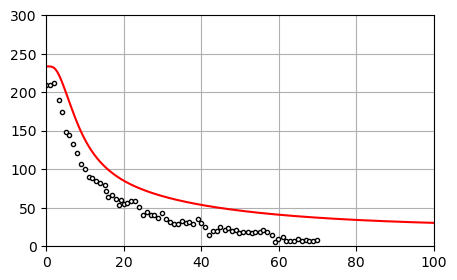

In [17]:
### EXP VALUES ###
msre_integral_worth = 'Data/msre_integral_rod_worth.csv'
msre_data = 'Data/msre_coastdown_datapoints.csv'

df = pd.read_csv(msre_integral_worth)
data = pd.read_csv(msre_data)

z = df['z'].values
rho = df[' rho'].values
pos = data['pos'].values
ornl_time_data = data['time'].values

values = np.interp(pos, z, rho)
base_insertion = values[0]

ornl_delta_rho_data = 1000*(values - startup_base_insertion) # this is the data we calculated based on experimental values

# MAKE PLOT
plt.figure(figsize=(5,3))
plt.plot(ornl_time_data, ornl_delta_rho_data, 'ko', markerfacecolor='w', markersize=3)

# COMPUTE STARTING VALUE
beff_no_flow = (0.006478751114635639 - 0.004142410989449852)*10**5

### MY VALUES ###
x = np.array(list(beta_eff_dict_mc.keys()))
y_MC = beta_eff_dict_mc[-0.1] - np.array(list(beta_eff_dict_mc.values()))
plt.plot(x, y_MC*10**5 + beff_no_flow, 'r-')
# plt.plot(x[0::50], y[0::50]*10**5, 'ks', markerfacecolor='w')
# plt.plot(x[0::50], y[0::50]*10**5, 'k+', markerfacecolor='w')

# OTHER PLOTTING STUFF
plt.grid()
plt.xlim([0,100])
plt.ylim([0,300])

In [18]:
beta_eff_dict_mc[-0.1]

np.float64(0.0043756770597340325)

In [19]:
import pickle as pkl
with open("Results/ANS_2025/channel_1_coastdown_beta_eff_results.pkl", "wb") as file:
    pkl.dump(beta_eff_dict_mc, file)
